In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 300.0 # modifying dots per inch for figures

In [3]:
num_pres = 2_000
simulation_length = 1_000 #ms

starting_hz = 54
min_r = 1
max_r = 90

min_dr_update = -360
max_dr_update = 360
min_dr = -1800
max_dr = 1800

In [4]:
def limited_cumsum(original, working, upper_limit, lower_limit):
    first_over = np.argmax(working>upper_limit)
    first_under = np.argmax(working<lower_limit)
    
    no_zero = True
    if first_over == 0 and first_over < first_under:
        #print(first_under)
        working[first_under:] = original[first_under:].cumsum()
        no_zero = False
        working = limited_cumsum(original, working, upper_limit, lower_limit)
    elif first_under == 0 and first_over > first_under:
        #print(first_over)
        working[first_over:] = original[first_over:].cumsum()
        no_zero = False
        working = limited_cumsum(original, working, upper_limit, lower_limit)
    
    if no_zero:
        if first_over < first_under:
            #print(first_over)
            working[first_over:] = original[first_over:].cumsum()
            working = limited_cumsum(original, working, upper_limit, lower_limit)
        elif first_over > first_under:
            #print(first_under)
            working[first_under:] = original[first_under:].cumsum()
            working = limited_cumsum(original, working, upper_limit, lower_limit)
    
    return working

In [5]:
def poisson_train_alt(duration=simulation_length+1):
    ds = np.random.uniform(min_dr_update, max_dr_update, duration)
    rdt = np.array(ds.cumsum())
    rdt = limited_cumsum(ds, rdt, max_dr, min_dr)
    r_w = np.insert(rdt[:-1], 0, starting_hz*1000)
    r = np.absolute(np.clip(r_w.cumsum()/1000, -90, 90))
    spikes = np.zeros((duration-1))
    for step in range(1, duration):
        if (step > 50) & (np.sum(spikes[step-50:step-1]) == 0):
            rnd_time = np.random.randint(step-50,step-1)
            spikes[rnd_time] = 1
            spikes[step-1] = 0
        else:
            spikes[step-1] = np.random.poisson(r[step-1]/1000)
    return np.clip(spikes, 0, 1)

In [6]:
def poisson_train(duration=simulation_length+1):
    spikes = []
    r = 54
    dr = 0
    for step in range(1, duration):
        if (step > 50) & (np.sum(spikes[step-50:step-1]) == 0):
            rnd_time = np.random.randint(step-50,step-1)
            spikes[rnd_time] = 1
            spikes.append(0)
        else:
            dr += np.random.uniform(min_dr_update, max_dr_update)
            dr = np.clip(dr, -1800, 1800)
            r += dr
            r = np.clip(r, 0, 90)/1000
            spikes.append(np.random.poisson(r))
    return np.clip(spikes, 0, 1)

In [7]:
tic = time.perf_counter()
pre_spikes = np.zeros([num_pres, simulation_length])
for pre in range(0, num_pres):
    pre_spikes[pre] = poisson_train()
toc = time.perf_counter()
print(toc-tic)

35.91127165499995


In [8]:
tic = time.perf_counter()
pre_spikes_alt = np.zeros([num_pres, simulation_length])
for pre in range(0, num_pres):
    pre_spikes_alt[pre] = poisson_train_alt()
toc = time.perf_counter()
print(toc-tic)

16.03009314299993


In [9]:
neuron_ids = []
spike_times = []
for neuron in range(0, 2000):
    for spike_time in range(0, 500):
        if pre_spikes[neuron,spike_time] == 1:
            neuron_ids.append(neuron)
            spike_times.append(spike_time)

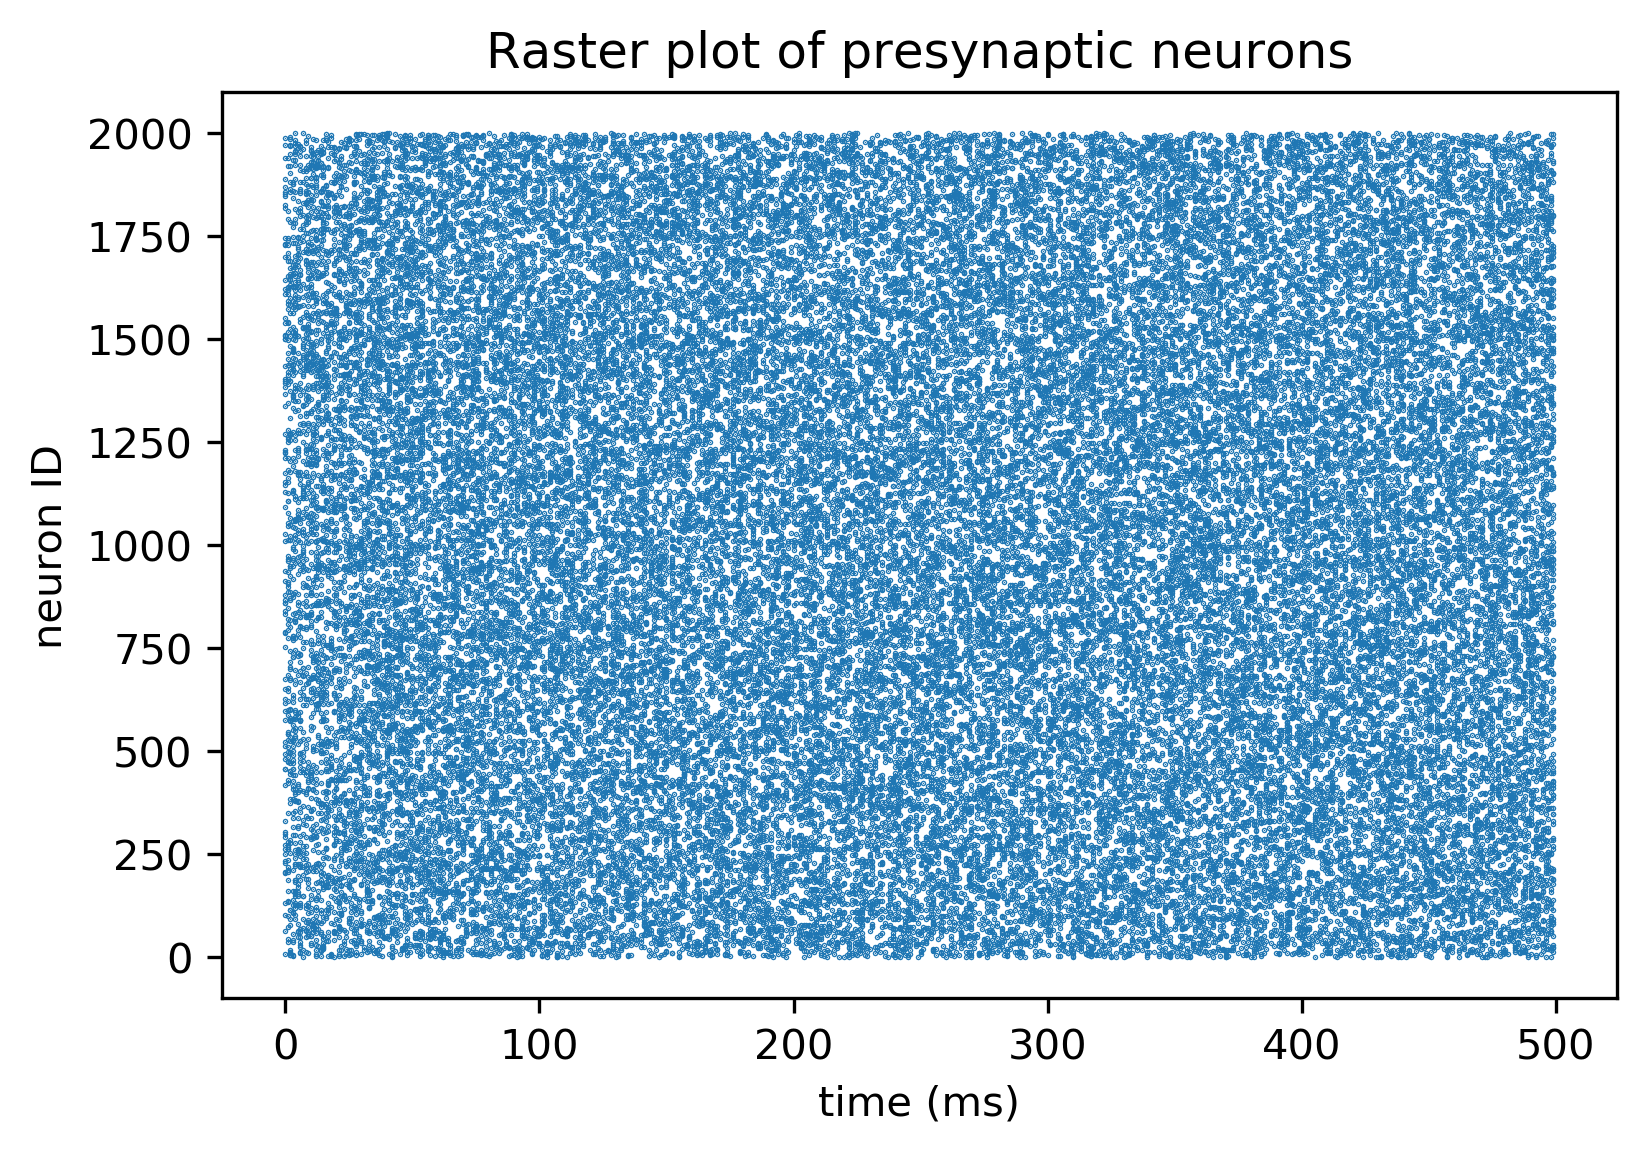

In [10]:
plt.scatter(spike_times,neuron_ids,s=0.1)
plt.title("Raster plot of presynaptic neurons")
plt.xlabel("time (ms)")
plt.ylabel("neuron ID")
plt.show()

In [11]:
firing_rates = []
for neuron in range(0, num_pres):
    firing_rates.append((np.sum(pre_spikes[neuron])/simulation_length)*1_000)

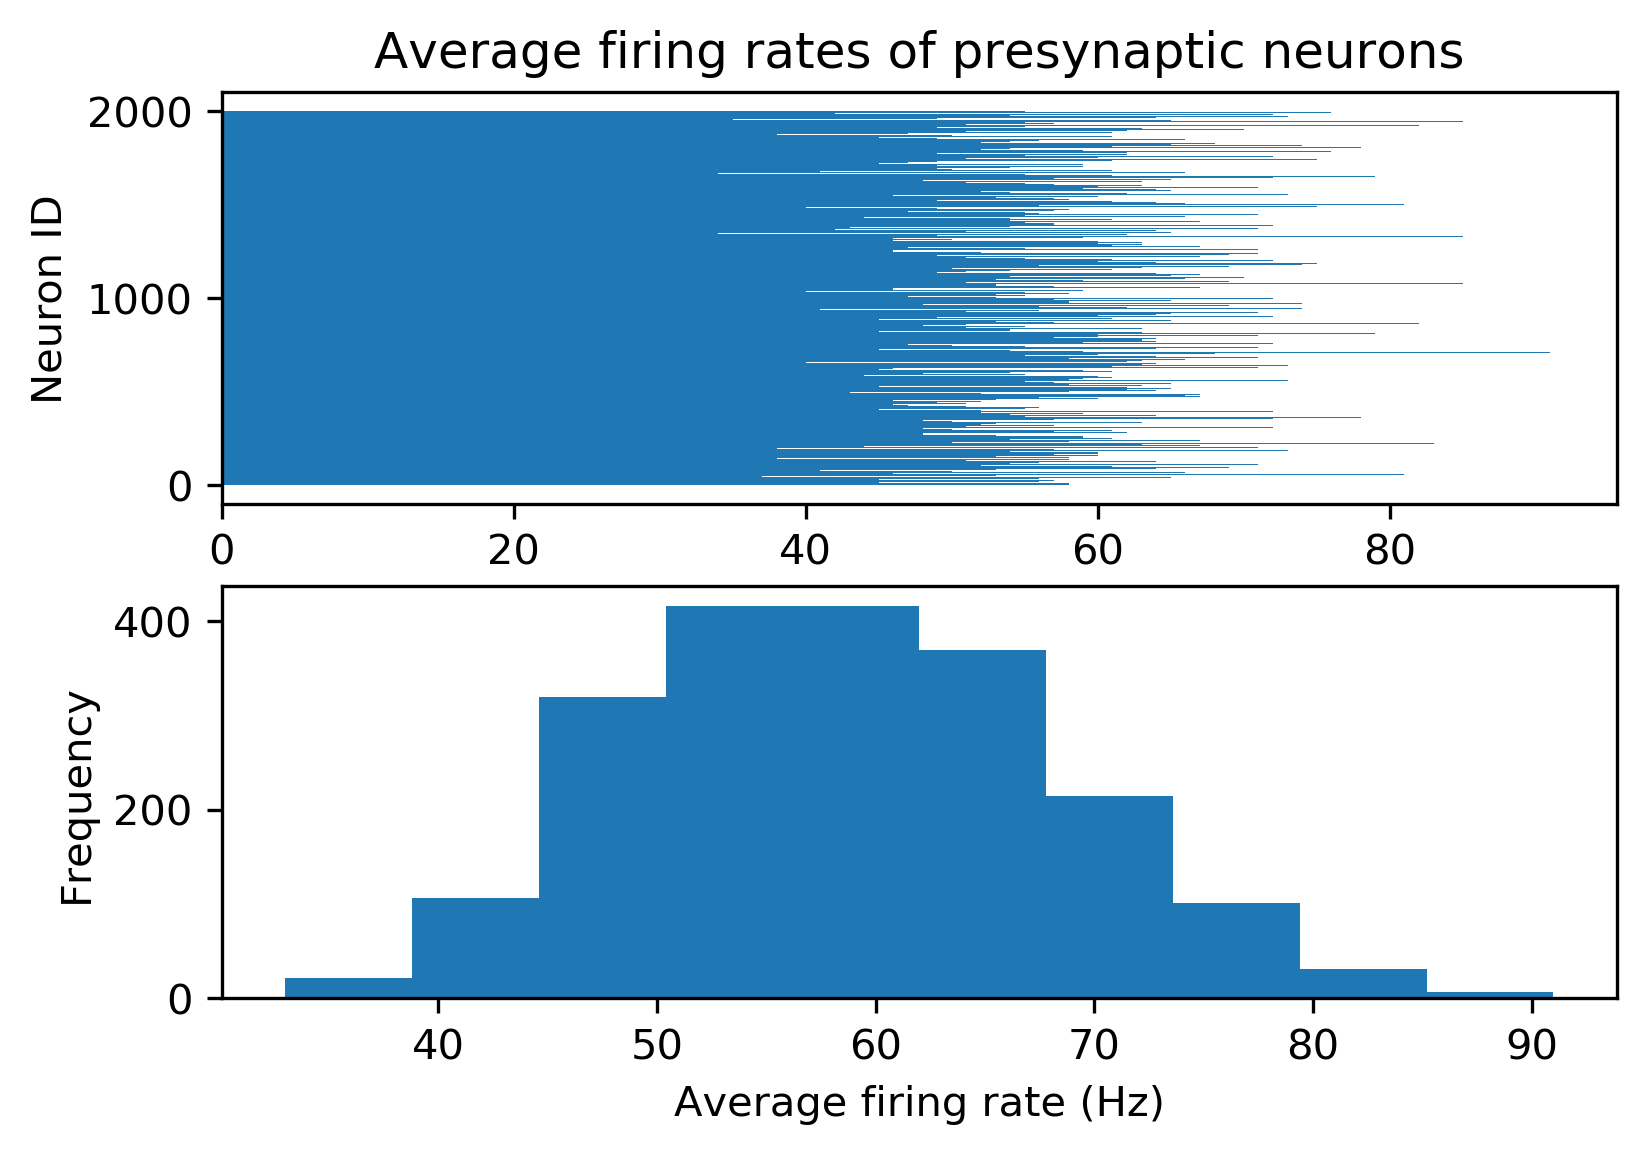

In [12]:
pre_IDs = list(range(0, num_pres))

fig, axes = plt.subplots(2, 1)

axes[0].barh(pre_IDs, firing_rates, height=1)
axes[0].set_title("Average firing rates of presynaptic neurons")
axes[0].set_ylabel("Neuron ID")

axes[1].hist(firing_rates)
axes[1].set_xlabel("Average firing rate (Hz)")
axes[1].set_ylabel("Frequency")

plt.show()

In [13]:
neuron_ids_alt = []
spike_times_alt = []
for neuron in range(0, 2000):
    for spike_time in range(0, 500):
        if pre_spikes_alt[neuron,spike_time] == 1:
            neuron_ids_alt.append(neuron)
            spike_times_alt.append(spike_time)

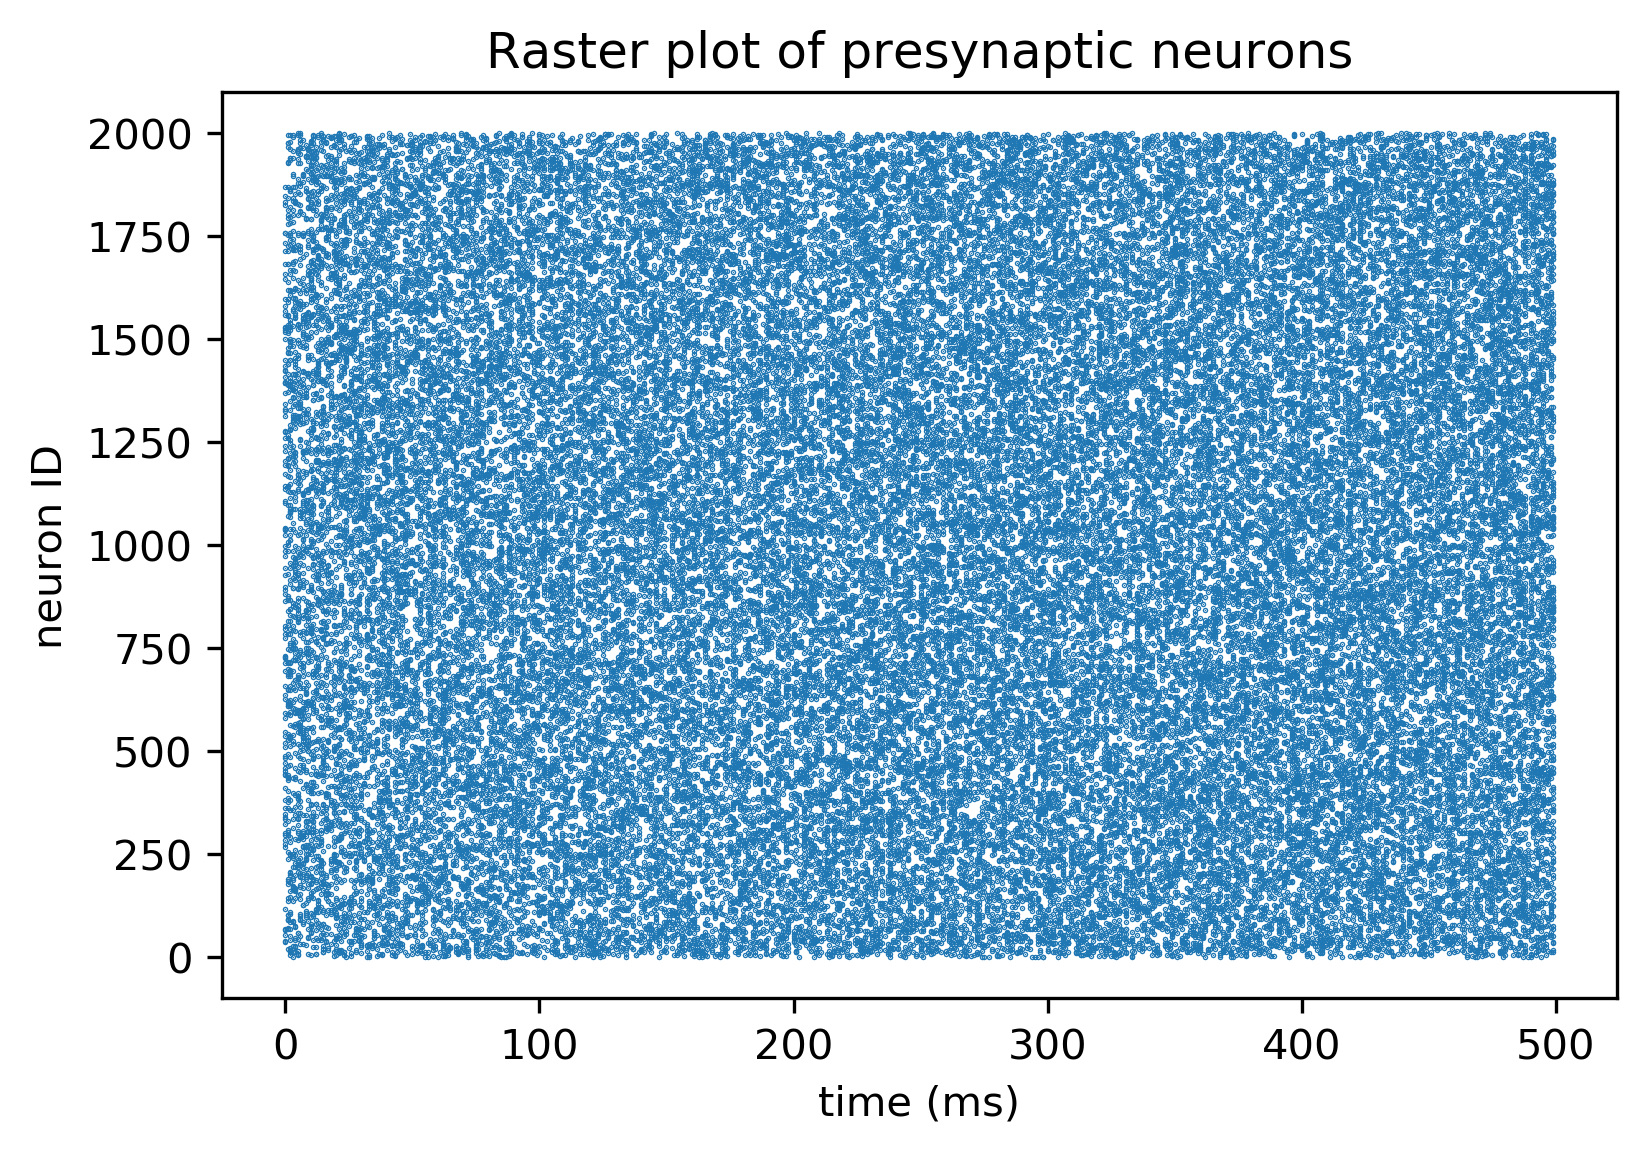

In [14]:
plt.scatter(spike_times_alt,neuron_ids_alt,s=0.1)
plt.title("Raster plot of presynaptic neurons")
plt.xlabel("time (ms)")
plt.ylabel("neuron ID")
plt.show()

In [15]:
firing_rates_alt = []
for neuron in range(0, num_pres):
    firing_rates_alt.append((np.sum(pre_spikes_alt[neuron])/simulation_length)*1_000)

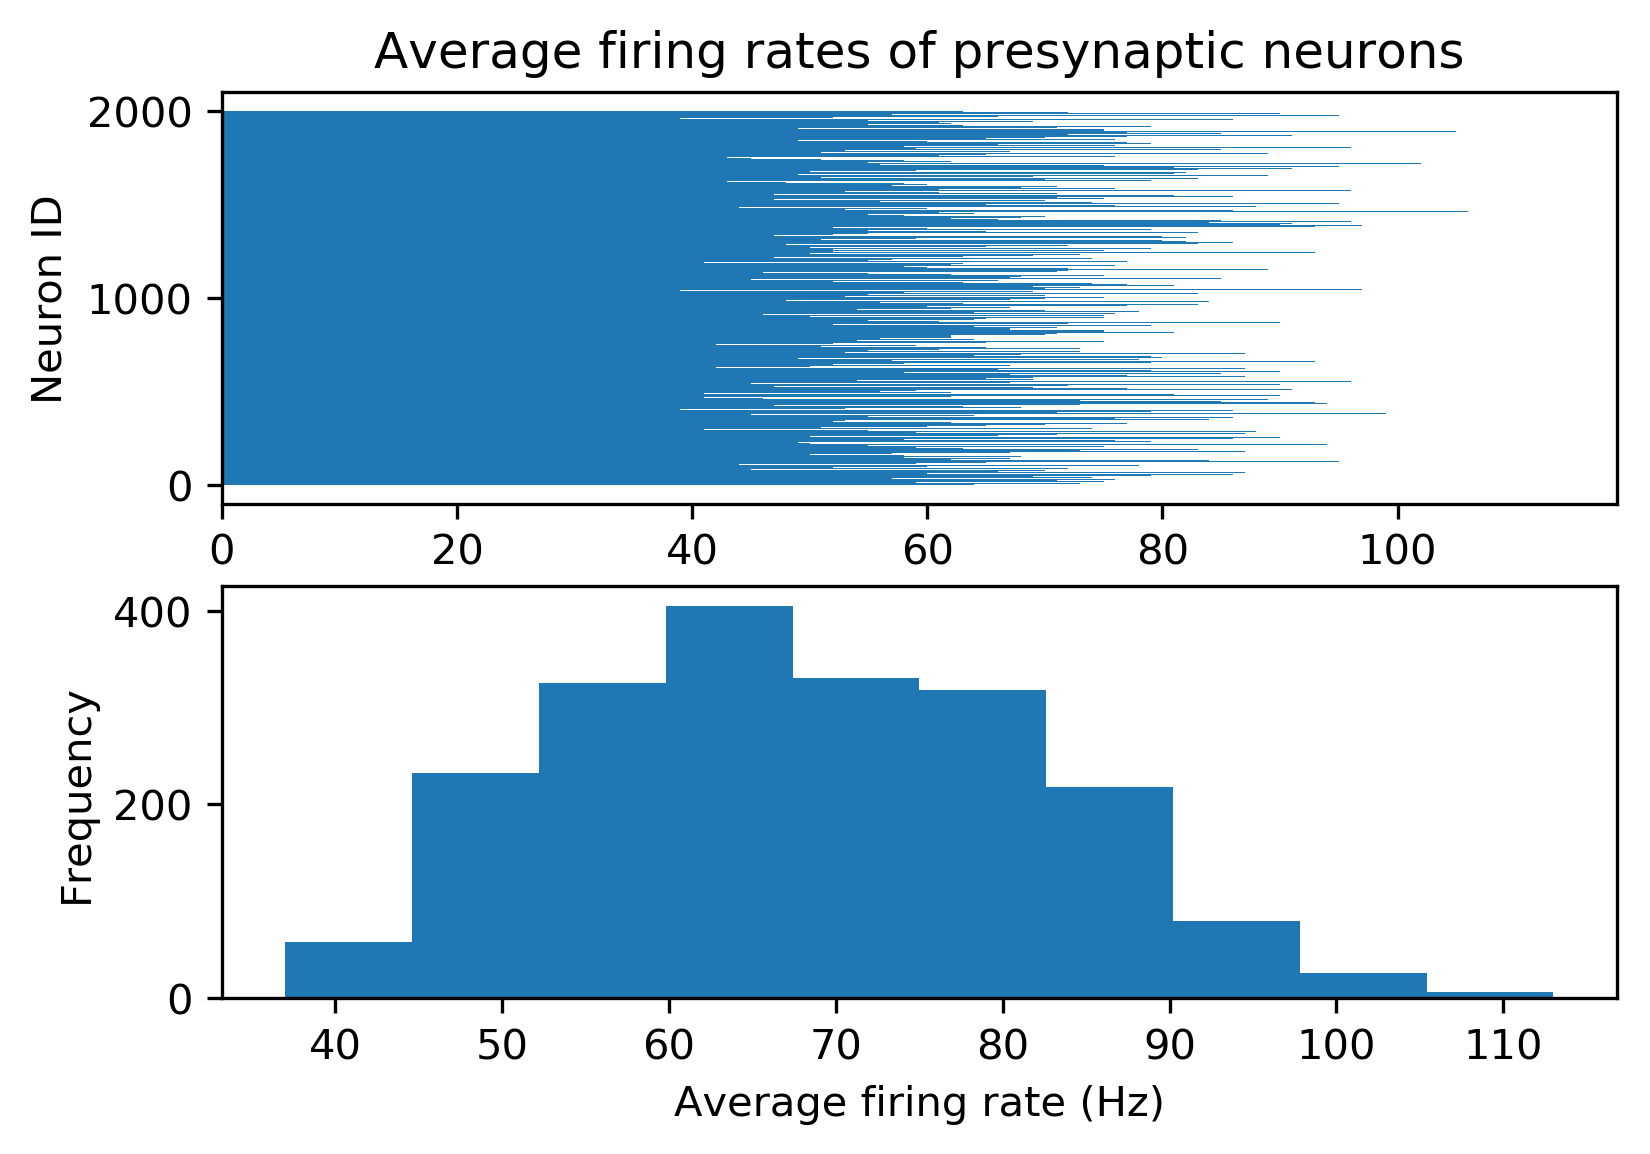

In [16]:
pre_IDs_alt = list(range(0, num_pres))

fig, axes = plt.subplots(2, 1)

axes[0].barh(pre_IDs_alt, firing_rates_alt, height=1)
axes[0].set_title("Average firing rates of presynaptic neurons")
axes[0].set_ylabel("Neuron ID")

axes[1].hist(firing_rates_alt)
axes[1].set_xlabel("Average firing rate (Hz)")
axes[1].set_ylabel("Frequency")

plt.show()

In [30]:
simulation_length_long = 100_000 #ms

In [31]:
pre_spikes_alt_long = np.zeros([num_pres, simulation_length_long])
tic = time.perf_counter()
for pre in range(0, num_pres):
    if pre % 25 == 0:
        print(pre)
    pre_spikes_alt_long[pre] = poisson_train_alt(simulation_length_long+1)
toc = time.perf_counter()

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875
1900
1925
1950
1975


In [33]:
np.shape(pre_spikes_alt_long)

(2000, 100000)

In [34]:
np.save('spont_100s_alt', pre_spikes_alt_long)

In [37]:
print((toc-tic)/60)

36.6275575387


In [38]:
pre_spikes_long = np.zeros([num_pres, simulation_length_long])
tic = time.perf_counter()
for pre in range(0, num_pres):
    if pre % 25 == 0:
        print(pre)
    pre_spikes_long[pre] = poisson_train(simulation_length_long+1)
toc = time.perf_counter()
print((toc-tic)/60)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875
1900
1925
1950
1975
60.897285558816655


In [39]:
np.save('spont_100s', pre_spikes_long)